In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from nplinker_constants import nplinker_setup
nplinker_setup()

In [37]:
from metabolomics import load_spectra

mgf_file = '/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/gnps_scripts/METABOLOMICS-SNETS-c36f90ba-download_clustered_spectra-main.mgf'
spectra = load_spectra(mgf_file)

Loaded 5930 molecules


In [38]:
nodes_file = '/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/gnps_scripts/0d51c5b6c73b489185a5503d319977ab..out'
with open(nodes_file,'rU') as f:
    for line in f:
        print line
        break

cluster index	number of spectra	parent mass	precursor charge	precursor mass	sum(precursor intensity)	-ve	A1	ARENICOLA	BAHAMAS	BUTANOL	CHANNELISLANDS	CNB091	CNB440	CNB458	CNB476	CNB527	CNB536	CNH099	CNH189	CNH287	CNH643	CNH646	CNH713	CNH718	CNH732	CNH877	CNH898	CNH905	CNH941	CNH962	CNH963	CNH964	CNH996	CNP082	CNP105	CNP193	CNQ149	CNQ329	CNQ525	CNQ748	CNQ766	CNQ768	CNQ865	CNQ884	CNR107	CNR114	CNR425	CNR510	CNR698	CNR699	CNR894	CNR909	CNR921	CNR942	CNS051	CNS055	CNS103	CNS143	CNS197	CNS205	CNS237	CNS243	CNS296	CNS299	CNS325	CNS335	CNS342	CNS416	CNS606	CNS615	CNS654	CNS673	CNS744	CNS801	CNS820	CNS848	CNS860	CNS863	CNS960	CNS991	CNS996	CNT001	CNT003	CNT005	CNT029	CNT045	CNT084	CNT088	CNT124	CNT131	CNT133	CNT138	CNT148	CNT150	CNT250	CNT261	CNT302	CNT318	CNT360	CNT371	CNT372	CNT403	CNT569	CNT584	CNT603	CNT609	CNT796	CNT798	CNT799	CNT800	CNT849	CNT850	CNT851	CNT854	CNT855	CNT857	CNT859	CNX435	CNX481	CNX482	CNX508	CNX814	CNX891	CNY011	CNY012	CNY202	CNY228	CNY230	CNY231	CNY234	CNY237	CNY239	CNY2

In [39]:
strains = "CNB091	CNB440	CNB458	CNB476	CNB527	CNB536	CNH099	CNH189	CNH287	CNH643	CNH646	CNH713	CNH718	CNH732	CNH877	CNH898	CNH905	CNH941	CNH962	CNH963	CNH964	CNH996	CNP082	CNP105	CNP193	CNQ149	CNQ329	CNQ525	CNQ748	CNQ766	CNQ768	CNQ865	CNQ884	CNR107	CNR114	CNR425	CNR510	CNR698	CNR699	CNR894	CNR909	CNR921	CNR942	CNS051	CNS055	CNS103	CNS143	CNS197	CNS205	CNS237	CNS243	CNS296	CNS299	CNS325	CNS335	CNS342	CNS416	CNS606	CNS615	CNS654	CNS673	CNS744	CNS801	CNS820	CNS848	CNS860	CNS863	CNS960	CNS991	CNS996	CNT001	CNT003	CNT005	CNT029	CNT045	CNT084	CNT088	CNT124	CNT131	CNT133	CNT138	CNT148	CNT150	CNT250	CNT261	CNT302	CNT318	CNT360	CNT371	CNT372	CNT403	CNT569	CNT584	CNT603	CNT609	CNT796	CNT798	CNT799	CNT800	CNT849	CNT850	CNT851	CNT854	CNT855	CNT857	CNT859	CNX435	CNX481	CNX482	CNX508	CNX814	CNX891	CNY011	CNY012	CNY202	CNY228	CNY230	CNY231	CNY234	CNY237	CNY239	CNY243	CNY244	CNY256	CNY260	CNY280	CNY281	CNY282	CNY330	CNY331	CNY363	CNY486	CNY498	CNY646	CNY666	CNY673	CNY678	CNY679	CNY681	CNY685	CNY690	CNY694	CNY703".split('\t')


In [40]:
from metabolomics import load_metadata
load_metadata(spectra,nodes_file)

In [41]:
print spectra[0].get_metadata_value('LibraryID')

None


In [42]:
from metabolomics import load_edges
edge_file = '/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/gnps_scripts/9a93d720f69143bb9f971db39b5d2ba2.pairsinfo'
load_edges(spectra,edge_file)
from metabolomics import make_families
families = make_families(spectra)

In [43]:
for spectrum in spectra:
    lid = spectrum.metadata['LibraryID']
    if lid:
        print spectrum.spectrum_id,lid

47672 Alteramide B
1810 Sorbitane Monopalmitate - Polysorbate 40 in-source fragment
1863 Sorbitane Monopalmitate - Polysorbate 40 in-source fragment
63393 Rosamicin
42939 Loperamide hydrochloride
63753 MLS000863563-01!1,11,22-trihydroxy-1,6,11,16,22,27-hexazacyclodotriacontane-2,5,12,15,23,26-hexone
63751 MLS000863563-01!1,11,22-trihydroxy-1,6,11,16,22,27-hexazacyclodotriacontane-2,5,12,15,23,26-hexone
65780 21-hydroxyrosamicin 
65843 21-hydroxyrosamicin 
65995 18-dihydro-21-hydroxyrosamicin 
67276 ReSpect:PT212210 Cyanidin-3-O-(2''-O-beta-glucopyranosyl-beta-glucopyranoside)|Cy 3-Soph|cyanidin-3-sophoroside|(2S,3R,4S,5S,6R)-2-[(2S,3R,4S,5S,6R)-2-[2-(3,4-dihydroxyphenyl)-5,7-dihydroxychromenylium-3-yl]oxy-4,5-di
1462 Massbank:FFF00098 24-Ethylcoprostanol
1369 Sorbitane Monopalmitate - Polysorbate 40 in-source fragment
1585 Sorbitane Monopalmitate - Polysorbate 40 in-source fragment
41255 Glycocholic acid
41256 Glycocholic acid
20859 Sevadicin
41296 Staurosporine
41297 Staurosporine
378

In [44]:
from genomics import loadBGC_from_node_files
import glob
node_file_list = glob.glob('/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/BGC/data/GCFs/Crusemann_only/*node.csv')
gcf_list,bgc_list, strain_list = loadBGC_from_node_files(node_file_list)

In [45]:
print len(gcf_list)

876


In [46]:
# initiate the random ones
for g in gcf_list:
    g.add_random(strain_list)
for s in spectra:
    s.add_random(strain_list)

In [48]:
from scoring import metcalf_scoring
m_scores = {}
best = 0
best_random = 0
for i,spectrum in enumerate(spectra[:1000]):
    m_scores[spectrum] = {}
    if i % 100 == 0:
        print i
    for gcf in gcf_list:
        s = metcalf_scoring(spectrum,gcf,strain_list)
        s_random = metcalf_scoring(spectrum.random_spectrum,gcf.random_gcf,strain_list)
        m_scores[spectrum][gcf] = (s,s_random)
        if s > best:
            best = s
            print "Best: ",best
        if s_random > best_random:
            best_random = s_random
            print "Best random: ",best_random

0
Best:  94
Best random:  94
Best random:  106
Best:  102
Best random:  110
Best:  110
Best random:  114
Best:  128
Best random:  115
Best random:  121
Best random:  124
Best random:  125
Best random:  126
Best random:  129
Best random:  130
Best random:  131
Best:  129
Best:  130
Best:  140
100
Best:  154
200
Best random:  139
300
400
500
600
700
800
900
Best random:  141


113
0.0144646118721


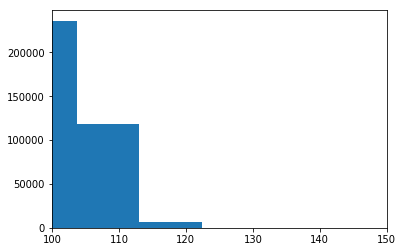

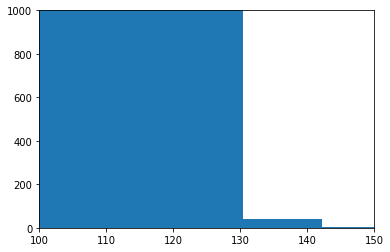

In [72]:
import pylab as plt
import numpy as np
%matplotlib inline
scores =[]
random_scores = []
for s,g in m_scores.items():
    for gg,sc in g.items():
        random_scores.append(sc[1])
        scores.append(sc[0])
plt.hist(random_scores,bins=50)
plt.xlim([100,150])
plt.figure()
plt.hist(scores,bins=50)
plt.xlim([100,150])
plt.ylim([0,1000])
random_scores.sort()
perc99 = random_scores[int(np.floor(0.99*len(random_scores)))]
print perc99
scores = np.array(scores)
n_above = len(np.where(scores>=perc99)[0])
print (1.0*n_above)/len(scores)

In [ ]:
best_spec = None
best_gcf = None
for spectrum in m_scores:
    for gcf in m_scores[spectrum]:
        if m_scores[spectrum][gcf] == best:
            best_spec = spectrum
            best_gcf = gcf

In [ ]:
print best_spec
print best_gcf
for strain in strain_list:
    print strain,best_spec.has_strain(strain),best_gcf.has_strain(strain)

In [ ]:
print best_spec.metadata['LibraryID']
for bgc in best_gcf.bgc_list:
    print bgc,bgc.bigscape_class,bgc.product_prediction

In [78]:
link_file = 'mibig_gnps_links_q3_loose.csv'
links = []
import csv
with open(link_file,'r') as f:
    reader = csv.reader(f)
    heads = reader.next()
    print heads
    for line in reader:
        links.append(line)

['#mibig_id', 'gnps_id', 'mibig_name', 'gnps_name']


In [98]:
link_dict = {}
for link in links:
    short_gnps_name = link[3].split()[0]
    link_dict[short_gnps_name] = link[0]    

In [102]:
spec_lib_dict = {}
for spectrum in spectra:
    if spectrum.metadata['LibraryID']:
        lid = spectrum.metadata['LibraryID'].split()[0]
        if lid in link_dict:
            spec_lib_dict[spectrum] = lid

In [107]:
for spec in spec_lib_dict:
    bgc_name = link_dict[spec_lib_dict[spec]]
    print bgc_name
    bgc = [b for b in bgc_list if b.name.startswith(bgc_name)]
    print bgc

BGC0000198
[]
BGC0001830
[]
BGC0000136
[]
BGC0001766
[]
BGC0001766
[]
BGC0001572
[]
BGC0000241
[]
BGC0000136
[]
BGC0001572
[]
BGC0000426
[]
BGC0000826
[]
BGC0000198
[]
BGC0000333
[]
BGC0001830
[]
BGC0001766
[]
BGC0000241
[]
BGC0000220
[]
BGC0000241
[]
BGC0000198
[]
BGC0000826
[]
BGC0001572
[]
BGC0001572
[]
BGC0000136
[]


In [106]:
print [b.name for b in bgc_list if b.name.startswith('BGC')]

['BGC0000181.1', 'BGC0001383.1', 'BGC0001031.1', 'BGC0001032.1', 'BGC0000995.1', 'BGC0001113.1', 'BGC0000418.1', 'BGC0000419.1', 'BGC0000995.1', 'BGC0001113.1', 'BGC0000064.1', 'BGC0001268.1', 'BGC0001096.1', 'BGC0000976.1', 'BGC0001165.1', 'BGC0000989.1', 'BGC0000990.1', 'BGC0001041.1', 'BGC0000991.1', 'BGC0001009.1', 'BGC0001010.1', 'BGC0000689.1', 'BGC0000697.1', 'BGC0001241.1', 'BGC0001267.1', 'BGC0001322.1', 'BGC0001324.1', 'BGC0000611.1', 'BGC0000655.1', 'BGC0000611.1', 'BGC0000655.1', 'BGC0000564.1', 'BGC0001170.1', 'BGC0000491.1', 'BGC0001222.1', 'BGC0000530.1', 'BGC0000533.1', 'BGC0000064.1', 'BGC0001268.1', 'BGC0000989.1', 'BGC0000991.1', 'BGC0000157.1', 'BGC0000158.1', 'BGC0001009.1', 'BGC0001010.1', 'BGC0001041.1', 'BGC0000976.1', 'BGC0001165.1', 'BGC0000958.1', 'BGC0001216.1', 'BGC0001340.1', 'BGC0001385.1', 'BGC0000004.1', 'BGC0000008.1', 'BGC0001259.1', 'BGC0001272.1', 'BGC0001264.1', 'BGC0001280.1', 'BGC0000006.1', 'BGC0000076.1', 'BGC0000077.1', 'BGC0000979.1', 'BGC000